MonBinMel MRI design
====================

This project will examine how and where ipRGC photoreceptor signals from each eye are integrated in the brain. The proposed design combines square wave monocular and binocular melanopsin-directed contrast transitions with brief sinusoidal LMS probes of varying intensity. This will allow us to map BOLD activation for monocular and binocular melanopsin stimulation in a basic block design whilst also measuring behavioral and BOLD responses to LMS probes under different levels of melanopsin stimulation. 

To date, only a handful of fMRI studies have examined the BOLD response to melanopsin stimulation. [Spitschan et al., (2016)](https://www.jneurosci.org/content/36/5/1471) measured BOLD activation to melanopsin-directed flicker across a range of frequencies (0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0 Hz) and did not find a cortical response that exceeded that of the control conditions. In a subsequent study, [Spitschan et al. (2017)](https://www.pnas.org/doi/10.1073/pnas.1711522114) presented 3 s pulses of melanopsin-directed contrast (25%, 50%, 100%, 200%, 400%) and observed BOLD activation in primary visual cortex that scaled with the contrast. The subjects in this experiment also reported that high-melanopsin contrast stimuli elicited a distinct perceptual experience, summarily described as an *"unpleasant, blurry, minimal brightening that quickly faded"*. 

Both of the aforementioned studies involved monocular stimulation with low sample sizes (*n* <= 4) and focused on cortical visual areas (e.g., V1-3, LOC, MT) in the analyses. However, a recent analysis by [Spitschan and Cajochen (2019)](10.1111/jpi.12602) of existing published data implies a substantial binocular facilitation effect for melanopsin stimulation with respect to melatonin suppression. This putative effect may present as increased BOLD activation in subthalamic ipRGC project sites such as the geniculate, suprachiasmatic and pretectal nuclei. The current design permits a LowMel < MonMel < BinMel analysis and is ideally suited to exploring the BOLD representation of this effect. Further, there is reason to believe that melanopsin contrast facilitates the processing of cone signals and influences brightness perception (e.g., [Brown et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22633808/); [Allen et al., 2014](https://doi.org/10.1016/j.cub.2014.09.015); [Davis et al., 2015](https://doi.org/10.1371/journal.pone.0123424)), so we might reasonably expect improved detection for the LMS probes and a greater BOLD signal in primary visual areas during the high-melanopsin conditions.

**Hypotheses**

 - ***$H_{0,1}$*** The BOLD signal in ipRGC projection targets (LGN, SCN, PN) will not differ across levels of melanopic stimulation.
 - ***$H_{1,1}$*** The BOLD signal in ipRGC projection targets (LGN, SCN, PN) will scale with the levels of melanopic stimulation (LowMel < MonMel < BinMel).
 - ***$H_{0,2}$*** Behavioural detection of LMS probes and associated cortical BOLD signals will not differ across melanopsin conditions.
 - ***$H_{1,2}$*** Behavioural detection of LMS probes and associated cortical BOLD signals will be facilitated by higher levels of melanopic stimulation.


Basic block design
------------------

Each block will last 360 s (*TR* = 3 s) and employ a basic 30 s off (LowMel) / 30 s on (HighMel) design. The HighMel stimulation is subdivided into monocular and binocular conditions. We therefore have the following conditions:

 - x6 **LowMel** (low melanopsin spectrum in both eyes)
 - x2 **MonLMel** (high melanopsin spectrum in the left eye)
 - x2 **MonRMel** (high melanopsin spectrum in the right eye)
 - x2 **BinMel** (high melanopsin spectrum in both eyes)

Each 30 s period will include four LMS probes at random non-overlapping time points. These probes serve as attention events but will also allow us to measure contrast sensitivity functions separately for monocular and binocular melanopsin conditions. The probes are 4 Hz sinusoidal LMS contrast modulations lasting 1 s, and will not occur within 3 s of a spectral transition. The following (michelson) contrast levels should be achievable:

 - 10.0%
 - 5.0%
 - 2.5%
 - 1.25%
 
 The code below creates the basic block design described above. 

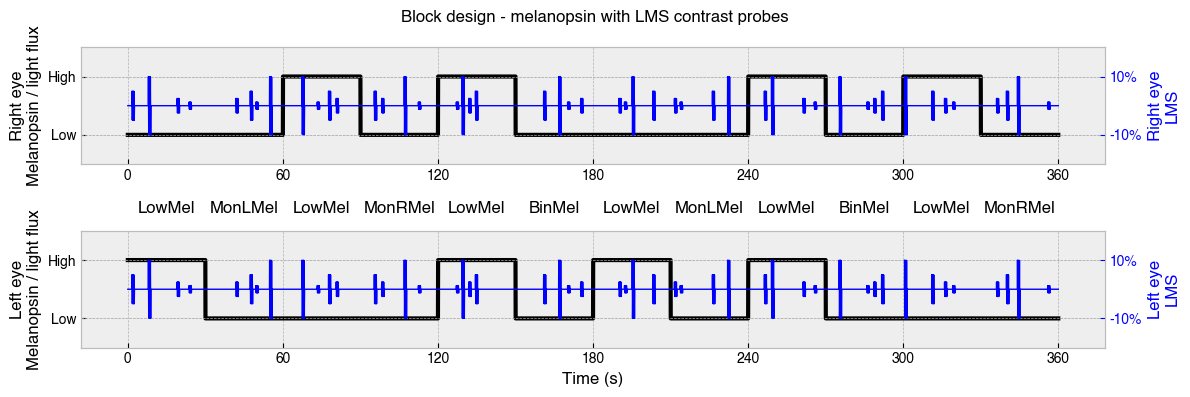

In [83]:
import random

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

from pysilsub import waves


# https://www.geeksforgeeks.org/python-non-overlapping-random-ranges/
def non_overlapping_ranges(n, width, low, high):
    """Find non-overlapping ranges for LMS probes."""
    # Maybe add an additional spacer parameter
    ranges = set()
    for _ in range(n):
        candidate = random.randint(low, high - width)
        while any(candidate >= (idx-(width*2)) 
                  and candidate <= (idx + (width*2)) 
                  for idx in ranges):
            candidate = random.randint(0, high - width)
        ranges.add(candidate)
    ranges = [(idx, idx + width) for idx in ranges]
    return ranges

# Parameters
Fs = 50  # Sampling frequency of STLABs
block_length = 360000  # ms
duration = 30  # Basic on-off duration

# Basic square wave
off = np.zeros(duration*Fs)
on = np.ones(duration*Fs)

# Full cycle for mel-on and mel-off conditions
meloff = np.hstack([off, off])
melon = np.hstack([on, off])

# Make conditions (separate stimulus profiles for each eye)
conditions = ['MonLMel', 'MonRMel', 'BinMel']
left_stims = []
right_stims = []
for i, c in enumerate(conditions * 2):
    
    if c == 'MonLMel':
        left = melon.copy()
        right = meloff.copy()
    
    if c == 'MonRMel':
        left = meloff.copy()
        right = melon.copy()
    
    if c == 'BinMel':
        left = melon.copy()
        right = melon.copy()
        
    # Save the stims
    left_stims.append(left)
    right_stims.append(right)

# Shuffle up the stims
shuffled = [(l, r, c) for (l, r, c) in zip(left_stims, right_stims, conditions * 2)]
random.shuffle(shuffled)
left_stims = [s[0] for s in shuffled]
right_stims = [s[1] for s in shuffled]
cons = [s[2] for s in shuffled]

# Full block melanopsin profile for each eye
left_mel = np.hstack(left_stims)
right_mel = np.hstack(right_stims)
time = np.linspace(0, block_length, len(right_mel)) / 1000

# Full block LMS profile (same for each eye)
lms_mod = waves.make_stimulus_waveform(frequency=4, sampling_frequency=Fs, duration=1)
lms = np.ones(len(left_mel)) / 2
lms_conditions = [.1, .05, .025, .0125]
lms_contrasts = []
lms_idxs = []
for idx in range(0, len(right_mel), 1500):
    # Use the non-overlapping ranges function to get idxs for LMS mods
    ranges = non_overlapping_ranges(n=4, width=50, low=150, high=1350)
    new = [(start+idx, end+idx) for (start, end) in ranges]
    lms_idxs += new
    random.shuffle(lms_conditions)
    lms_contrasts += lms_conditions
    
for i, c in zip(lms_idxs, lms_contrasts):
    lms[i[0]:i[1]] = lms[i[0]:i[1]] + (lms_mod*c*5)
    

# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 4))
axs[0].plot(time, right_mel, lw=3, c='k')
axs[0].set_ylabel('Right eye\nMelanopsin / light flux')
axs[1].plot(time, left_mel, lw=3, c='k')
axs[1].set_ylabel('Left eye\nMelanopsin / light flux')
axs[1].set_xlabel('Time (s)')
for ax in axs:
    ax.set_ylim((-.5, 1.5))
    ax.set_yticks((0,1), ['Low', 'High'])
    
# lms axis
ax1 = axs[0].twinx()
ax2 = axs[1].twinx()

ax1.plot(time, lms, lw=1, c='b')
ax2.plot(time, lms, lw=1, c='b')
ax1.set_ylabel('Right eye\nLMS', color='b')
ax2.set_ylabel('Left eye\nLMS', color='b')
for ax in [ax1, ax2]:
    ax.set_ylim((-.5, 1.5))
    ax.tick_params(axis='y', colors='b')
    ax.set_yticks((0,1), ['-10%', '10%'])
    ax.set_xticks(np.arange(min(time), max(time)+1, 60))


# Add conditions
for x, t in zip(range(45, 361, 60), cons):
    plt.text(x, 1.8, t, horizontalalignment='center', fontsize=12)

for x, t in zip(range(15, 361, 60), ['LowMel']*6):
    plt.text(x, 1.8, t, horizontalalignment='center', fontsize=12)

fig.suptitle('Block design - melanopsin with LMS contrast probes')
plt.tight_layout()


In [84]:
# Save the events for FSL
events = (
    pd.concat(
        [
            pd.DataFrame(zip(range(30, 360, 60), cons), columns=['Onset', 'Event']),
            pd.DataFrame(zip(range(0, 360, 60), ['LowMel']*6), columns=['Onset', 'Event']),
            pd.DataFrame(sorted(zip([l[0]/50 for l in lms_idxs], ['LMS']*len(lms_contrasts), lms_contrasts)),
                         columns=['Onset', 'Event', 'Cm'])
        ]
    ).sort_values(by='Onset').reset_index(drop=True)
)
pd.set_option('display.max_rows', 100)
events.loc[events['Event']=='LMS', 'Duration'] = 1
events.loc[events['Event']!='LMS', 'Duration'] = 30
events

,Onset,Event,Cm,Duration
0,0.00,LowMel,NaN,30.0
1,1.54,LMS,0.0500,1.0
2,7.90,LMS,0.1000,1.0
3,19.02,LMS,0.0250,1.0
4,23.64,LMS,0.0125,1.0
5,30.00,MonLMel,NaN,30.0
6,41.76,LMS,0.0250,1.0
7,47.32,LMS,0.0500,1.0
8,49.46,LMS,0.0125,1.0
9,54.80,LMS,0.1000,1.0


# Finding STLAB settings

The following process seems to work well for realising the above design. 

 1. Start with the dimmer device (STLAB 2, right eye). That way, we should always be able to optimise the settings to the other device.
 2. Search for a pair of spectra that maximise melanopsin contrast (assuming standard 32-year-old observer with 10-degree field size), but constraining every other primary to roughly half of its maximum input. This should help ensure a rod saturating baseline and reserve room in the gamut for LMS modulations. 
 3. Create a sub-problem with the constrained primaries and use this to implement the LMS modulations algebraically. 
 4. Optimise all spectra to the other device.
 5. Tune the spectra to individual observers (optional, probably not required).

In [ ]:
import os
import os.path as op
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from pysilsub.problems import SilentSubstitutionProblem
from pysilsub.binocular import BinocularStimulationDevice

S2 = SilentSubstitutionProblem.from_package_data('STLAB_2_York')

# Primary bounds to use in optimisation
bounds = [(0.0, 1.0) for primary in range(S2.nprimaries)]

# Constrain every other primary to half-maximum. Later we will use
# these primaries as the background spectrum for LMS modulations.
constrain = [1,3,5,7,9]
for led in constrain:
    bounds[led] = (.4999,.5001)
          
# Define the problems
S2.ignore = ['rh']
S2.target = ['mel']
S2.silence = ['sc', 'mc', 'lc']                
S2.bounds = bounds
S2.target_contrast = 'max'

# Find a High-Mel solution
solution_2 = S2.optim_solve(global_search=True, niter=10) 

# The low and high melanopsin spectrum settings
s2_low_mel = solution_2.x[0:10]
s2_high_mel = solution_2.x[10:]

# Assign the background
S2.background = s2_low_mel

# Plot the solutions
fig2 = S2.plot_solution(s2_high_mel)

# These are the contrasts in each eye
print('STLAB_2 photoreceptor contrasts:')
print(S2.print_photoreceptor_contrasts(s2_high_mel))

# Settings for device 2
print(f'STLAB_2 High-Mel settings: {S2.w2s(s2_high_mel)}')
print(f'STLAB_2 Low-Mel settings: {S2.w2s(s2_low_mel)}')


~~~~~~~~~~~~~~~~~~~~~~~ optim_solve ~~~~~~~~~~~~~~~~~~~~~~~~
> No background specified, will optimise background.
> Aiming to maximise contrast.
> Performing global optimization with basinhopping and SLSQP
basinhopping step 0: f -0.0538382


## Matching the low and high melanopsin spectra

> Optimising settings. Matching left to right


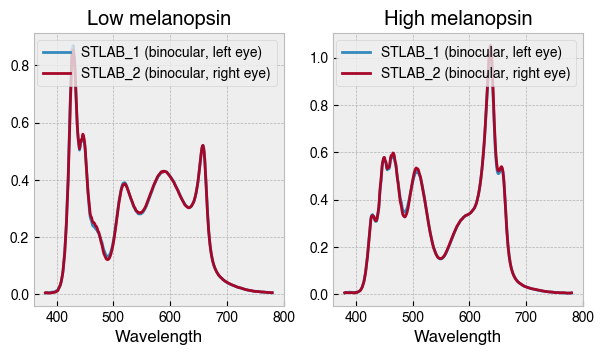

In [8]:
S1 = SilentSubstitutionProblem.from_package_data('STLAB_1_York')
S2 = SilentSubstitutionProblem.from_package_data('STLAB_2_York')

# Match the spectra in the other device
Sbin = BinocularStimulationDevice(S1, S2)
Sbin.anchor = 'right'  # The less bright of the two
Sbin.optim = 'left'
s2_settings = [s2_low_mel, s2_high_mel]
s1_settings = Sbin.optimise_settings(s2_settings)

# Plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(7.08, 3.54))

# Low mel
S1.predict_multiprimary_spd(s1_settings[0]).plot(ax=axs[0], label=S1.name)
S2.predict_multiprimary_spd(s2_settings[0]).plot(ax=axs[0], label=S2.name)

# High mel
S1.predict_multiprimary_spd(s1_settings[1]).plot(ax=axs[1], label=S1.name)
S2.predict_multiprimary_spd(s2_settings[1]).plot(ax=axs[1], label=S2.name)

axs[0].set_title('Low melanopsin')
axs[1].set_title('High melanopsin')

for ax in axs:
    ax.legend(loc='best')

LMS modulations
---------------

To make the LMS modulations, we can create a sub-problem using the primaries that were constrained in the original optimisation.

In [77]:
import copy

S2_lum = copy.copy(S2)
S2_lum.nprimaries = 5
S2_lum.primaries = constrain
S2_lum.calibration = S2_lum.calibration.loc[constrain]
S2_lum.ignore = ['rh']
S2_lum.target = ['sc', 'mc', 'lc']
S2_lum.silence = ['mel']
S2_lum.background = s2_high_mel[constrain]
S2_lum.bounds = [(0.0, 1.0) for primary in range(S2_lum.nprimaries)]
S2_lum.print_problem()

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_2 (binocular, right eye)
Observer: ColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh']
Silencing: ['mel']
Targeting: ['sc', 'mc', 'lc']
Target contrast: None
Background: [ 0.50793716  0.50807918  0.49        0.51        0.51      ]




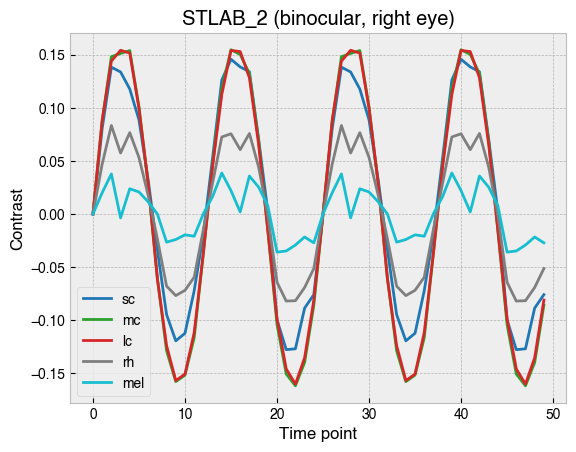

In [5]:
s2_h_lms = S2_lum.make_contrast_modulation(
    frequency=4, 
    sampling_frequency=50, 
    target_contrast=.15, 
    duration=1
)
_ = S2_lum.plot_contrast_modulation(s2_h_lms)

## Matching the LMS modulations

In [6]:
def combine_settings(background, modulation):
    settings = []
    constrain= [1,3,5,7,9]
    for mod in modulation:
        new = background.copy()
        new[constrain] = mod
        settings.append(new)
    return settings

s1_h_lms = Sbin.optimise_settings(combine_settings(s2_high_mel, s2_h_lms))


> Optimising settings. Matching left to right


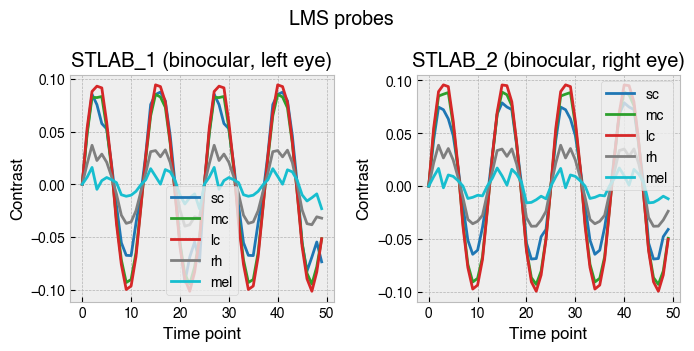

In [7]:
S1.background = s1_settings[1]  # High mel
S2.background = s2_settings[1]  # High mel

fig, axs = plt.subplots(1, 2, figsize=(7.08, 3.54))

_ = S1.plot_contrast_modulation(s1_h_lms, ax=axs[0])
_ = S2.plot_contrast_modulation(combine_settings(s2_settings[1], s2_h_lms), ax=axs[1])

fig.suptitle('LMS probes', fontsize=14)
plt.tight_layout()